# 1: Exploratory Analysis

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipydisp

from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
import h2o
from h2o.frame import H2OFrame
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator

In [2]:
%matplotlib inline
pd.options.mode.chained_assignment = None

### Outcomes

We first look at the metrics that DonorsChoose.org identified as designating "excitement." Funding does not appear to be an issue, as the majority of projects are fully funded. Having "great chat" on the website, as determined by DonorsChoose.org, appears at first to be a limiting requirement for the "exciting" designation.

In [3]:
outcomes = pd.read_csv("outcomes.csv")
print("Number of projects in outcomes.csv: ", outcomes['projectid'].nunique(), "\n")

outcomes.fillna('f', inplace=True)
outcomes.replace(['t', 'f'], [1, 0], inplace=True)

ntiles = [.05, .25, .5, .75, .95]

outcomes[['at_least_1_teacher_referred_donor', 
             'fully_funded', 
             'at_least_1_green_donation', 
             'great_chat', 
             'three_or_more_non_teacher_referred_donors', 
             'one_non_teacher_referred_donor_giving_100_plus', 
             'donation_from_thoughtful_donor', 
             'is_exciting']].agg(np.mean).round(2)

Number of projects in outcomes.csv:  619326 



at_least_1_teacher_referred_donor                 0.20
fully_funded                                      0.70
at_least_1_green_donation                         0.61
great_chat                                        0.30
three_or_more_non_teacher_referred_donors         0.44
one_non_teacher_referred_donor_giving_100_plus    0.61
donation_from_thoughtful_donor                    0.01
is_exciting                                       0.06
dtype: float64

In [4]:
outcome_flags = pd.DataFrame(dict(projectid=outcomes['projectid'],
                                  fully_funded=outcomes['fully_funded'],
                                  fully_funded_flag=outcomes['fully_funded'].replace([1, 0], 
                                                                                ["Fully funded", "Not fully funded"]),
                                  is_exciting=outcomes['is_exciting'],
                                  is_exciting_flag=outcomes['is_exciting'].replace([1, 0], 
                                                                              ["Exciting", "Not exciting"]),
                                  great_chat=outcomes['great_chat'],
                                  great_chat_flag=outcomes['great_chat'].replace([1, 0], 
                                                                            ["Great chat", "Not great chat"])))

## Data schema and relationship

In [5]:
projects = pd.read_csv("projects.csv")
                    
projects = pd.merge(projects,
                    outcome_flags,
                    on='projectid')

for school_type in ['school_charter', 'school_magnet', 'school_year_round', 
                    'school_nlns', 'school_kipp', 
                    'school_charter_ready_promise']:
    projects[school_type].replace(['t', 'f'], [1, 0], inplace=True)

projects_per_teacher = projects.groupby('teacher_acctid').agg({'projectid': 'count'})
projects_per_school = projects.groupby('schoolid').agg({'projectid': 'count'})

We begin by looking at participating schools, and see that the median teacher submits 2-3 projects through the website. Most schools request funding for fewer than 20 projects, and most projects tend to reach a single classroom's worth of students. These values fall off exponentially, with many extreme outliers due to anomalous issues in self reporting (example: claiming to reach 999999 students).

In [6]:
pd.DataFrame(dict(
    projects_per_teacher=projects_per_teacher['projectid'].describe(ntiles),
    projects_per_school=projects_per_school['projectid'].describe(ntiles),
    students_reached=projects['students_reached'].describe(ntiles)
)).round(1)

,projects_per_school,projects_per_teacher,students_reached
count,55296.0,236289.0,619182.0
mean,11.2,2.6,97.4
std,25.4,5.3,2364.1
min,1.0,1.0,0.0
5%,1.0,1.0,12.0
25%,2.0,1.0,22.0
50%,4.0,1.0,30.0
75%,10.0,2.0,100.0
95%,45.0,8.0,400.0
max,902.0,246.0,999999.0


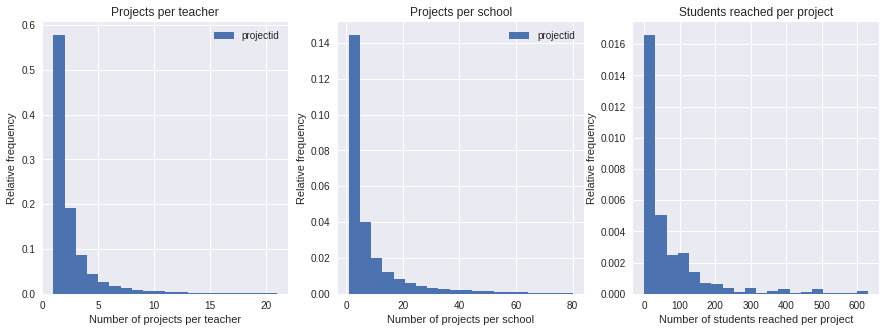

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(15, 5)

projects_per_teacher[projects_per_teacher < projects_per_teacher.quantile(.99)].plot.hist(bins=20, 
                                                                                          normed=True,
                                                                                          ax=ax1)
ax1.set_xlabel("Number of projects per teacher")
ax1.set_ylabel("Relative frequency")
ax1.set_title("Projects per teacher")

ax2 = projects_per_school[projects_per_school < projects_per_school.quantile(.98)].plot.hist(bins=20, 
                                                                                             normed=True,
                                                                                             ax=ax2)
ax2.set_xlabel("Number of projects per school")
ax2.set_ylabel("Relative frequency")
ax2.set_title("Projects per school")

projects[projects['students_reached'] <= projects['students_reached'].quantile(.98)]\
    ['students_reached'].plot.hist(bins=20, 
                                   normed=True, 
                                   ax=ax3)
ax3.set_xlabel("Number of students reached per project")
ax3.set_ylabel("Relative frequency")
ax3.set_title("Students reached per project")

## Project outcomes by school factors

Next, we look at school-dependent factors and their common traits. The average teacher submitting a project proposal tends to be from a high povety elementary school, and more projects request supplies as the primary resource type versus any other resource type. This might explain why "great chat" is a limiting factor above for determining excitement, since many users on DonorsChoose.org request routine supplies at underfunded schools in modest amounts, which may not be "exciting" from the business perspective in terms of driving conversation about individual project proposals.

In [8]:
projects[['poverty_level', 
          'grade_level',
          'teacher_prefix',
          'primary_focus_subject',
          'secondary_focus_subject',
          'resource_type']].describe()

,poverty_level,grade_level,teacher_prefix,primary_focus_subject,secondary_focus_subject,resource_type
count,619326,619319,619326,619290,425377,619283
unique,4,4,5,27,27,6
top,highest poverty,Grades PreK-2,Mrs.,Literacy,Literature & Writing,Supplies
freq,358324,228733,295266,188604,65217,214170


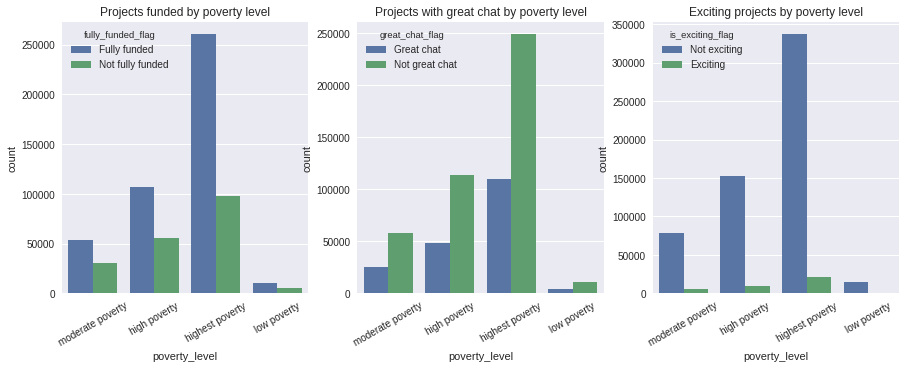

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(15, 5)

sns.countplot(x="poverty_level", hue="fully_funded_flag", data=projects, ax=ax1)
ax1.set_title("Projects funded by poverty level")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=30)

sns.countplot(x="poverty_level", hue="great_chat_flag", data=projects, ax=ax2)
ax2.set_title("Projects with great chat by poverty level")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30)

sns.countplot(x="poverty_level", hue="is_exciting_flag", data=projects, ax=ax3)
ax3.set_title("Exciting projects by poverty level")
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=30)

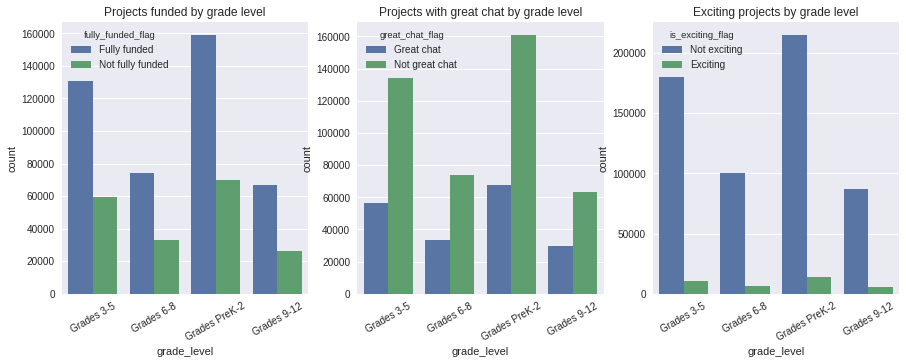

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(15, 5)

sns.countplot(x="grade_level", hue="fully_funded_flag", data=projects, ax=ax1)
ax1.set_title("Projects funded by grade level")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=30)

sns.countplot(x="grade_level", hue="great_chat_flag", data=projects, ax=ax2)
ax2.set_title("Projects with great chat by grade level")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30)

sns.countplot(x="grade_level", hue="is_exciting_flag", data=projects, ax=ax3)
ax3.set_title("Exciting projects by grade level")
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=30)

Next, we look at school types. At first, we see that charter schools and KIPP schools tend to have better than average odds of proposing "exciting" projects; we will look at this more in the case study. We also look at projects by resource type; although resource types affect the likelihood of funding and discussion, they have relatively little impact on the "exciting" designation.

In [11]:
projects.agg({col: np.mean for col in ['school_charter', 'school_magnet', 'school_year_round', 
                                        'school_nlns', 'school_kipp', 
                                        'school_charter_ready_promise']}).round(2)

school_charter                  0.09
school_magnet                   0.09
school_year_round               0.05
school_nlns                     0.02
school_kipp                     0.01
school_charter_ready_promise    0.01
dtype: float64

In [12]:
school_type_aggs = {}
for school_type in ['school_charter', 'school_magnet', 'school_year_round', 
                    'school_nlns', 'school_kipp', 
                    'school_charter_ready_promise']:
    target_data = projects[projects[school_type] == 1]
    school_type_aggs[school_type.replace('school_', '')] = (target_data['fully_funded'].mean(),
                                                            target_data['great_chat'].mean(),
                                                            target_data['is_exciting'].mean())
    
school_type_results = pd.DataFrame.from_dict(school_type_aggs).T.round(2)
school_type_results.columns = ['fully_funded', 'great_chat', 'is_exciting']

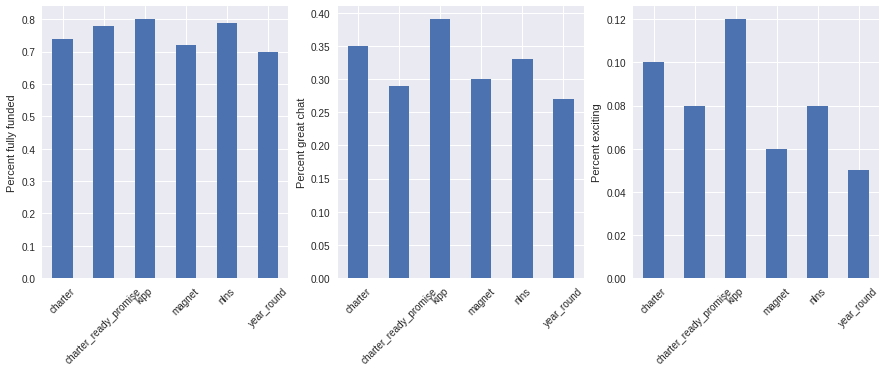

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(15, 5)

school_type_results['fully_funded'].plot(kind='bar', rot=45, ax=ax1)
ax1.set_ylabel("Percent fully funded")

school_type_results['great_chat'].plot(kind='bar', rot=45, ax=ax2)
ax2.set_ylabel("Percent great chat")

school_type_results['is_exciting'].plot(kind='bar', rot=45, ax=ax3)
ax3.set_ylabel("Percent exciting")

In [14]:
resource_types = projects.groupby('resource_type').agg({'projectid': 'count',
                                       'fully_funded': np.mean,
                                       'great_chat': np.mean,
                                       'is_exciting': np.mean})
resource_types.loc[:, "pct_projects"] = \
    resource_types['projectid'].astype(float) / resource_types['projectid'].sum()
resource_types.drop('projectid', axis=1, inplace=True)
resource_types.rename(columns={'fully_funded': 'pct_fully_funded',
                               'great_chat': 'pct_great_chat', 
                               'is_exciting': 'pct_is_exciting'}).round(2)

,pct_fully_funded,pct_great_chat,pct_is_exciting,pct_projects
resource_type,,,,
Books,0.76,0.33,0.07,0.22
Other,0.69,0.32,0.07,0.11
Supplies,0.73,0.31,0.06,0.35
Technology,0.61,0.27,0.05,0.32
Trips,0.74,0.20,0.05,0.01
Visitors,0.67,0.25,0.05,0.00


## Resource Analysis

Next we look at the individual resources requested and the distributions of how they are itemized. Most projects request less than 100 items and cost less than $1000.00 in total. Most outlying expensive projects ask for a few expensive items, and most projects that ask for an outlying number of items ask only for inexpensive items.

In [15]:
resources = pd.read_csv("resources.csv")
print("Number of projects in resources.csv: ", resources['projectid'].nunique(), "\n")

Number of projects in resources.csv:  663773 



In [16]:
resources.loc[:, "total_item_cost"] = resources['item_unit_price'] * resources['item_quantity']

resources_agg = resources.groupby('projectid').agg({'item_quantity': np.sum, 
                                                    'total_item_cost': np.sum}).reset_index()

In [17]:
pd.DataFrame(dict(
    item_quantity=resources_agg['item_quantity'].describe(),
    total_item_cost=resources_agg['total_item_cost'].describe()
)).round(2)

,item_quantity,total_item_cost
count,656418.00,6.556620e+05
mean,18.43,1.140750e+03
std,1226.26,5.539312e+05
min,1.00,0.000000e+00
25%,2.00,2.172300e+02
50%,6.00,3.490000e+02
75%,21.00,4.999900e+02
max,993133.00,4.484220e+08


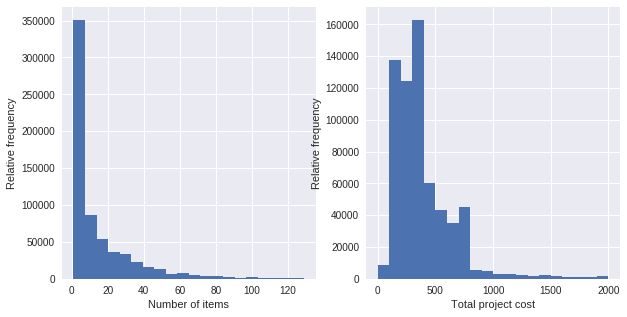

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

resources_agg[resources_agg['item_quantity'] < resources_agg['item_quantity'].quantile(.99)]\
    ['item_quantity'].hist(bins=20, ax=ax1)
ax1.set_xlabel("Number of items")
ax1.set_ylabel("Relative frequency")

resources_agg[resources_agg['total_item_cost'] < resources_agg['total_item_cost'].quantile(.99)]\
    ['total_item_cost'].hist(bins=20, ax=ax2)
ax2.set_xlabel("Total project cost")
ax2.set_ylabel("Relative frequency")

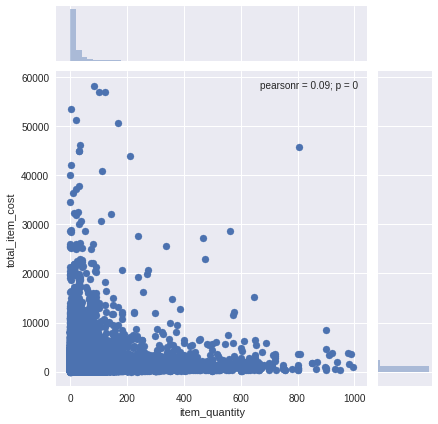

In [19]:
sns.jointplot(data=resources_agg[(resources_agg['item_quantity'] < 1000) &
                                 (resources_agg['total_item_cost'] < 60000)], 
              x='item_quantity', y='total_item_cost')

In [20]:
print("Number of projects in projects dataframe before resources merge: ", projects['projectid'].nunique(), "\n")
projects = pd.merge(projects, resources_agg, on='projectid')
print("Number of projects in projects dataframe after resources merge: ", projects['projectid'].nunique(), "\n")

Number of projects in projects dataframe before resources merge:  619326 

Number of projects in projects dataframe after resources merge:  619001 



It is worth noting that the data has some minor discrepancies in how the total costs are calculated; we are provided with the total cost of items requested and the cost of labor fulfillment, but this underestimated the reported total price (excluding optional support). 

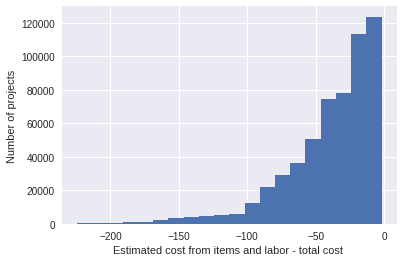

In [21]:
projects.loc[:, 'item_cost_diff'] = \
    projects['total_item_cost'] + projects['fulfillment_labor_materials'] - projects['total_price_excluding_optional_support'] 

ax = projects[(projects['item_cost_diff'].quantile(.01) < projects['item_cost_diff']) &
         (projects['item_cost_diff'] < projects['item_cost_diff'].quantile(.99))]['item_cost_diff'].hist(bins=20)
ax.set_xlabel("Estimated cost from items and labor - total cost ")
ax.set_ylabel("Number of projects")

Additionally, we look at items per student and cost per student. Most resources are bought with the intent to share them among many students, most likely all the students within a teacher's classroom (as shown by the students reached per project, duplicated here). Again, these all fall off exponentially with some extreme outliers due to anomalous self reporting.

In [22]:
projects.loc[:, 'items_per_student'] = projects['item_quantity'] / projects['students_reached']
projects.loc[:, 'cost_per_student'] = projects['total_price_excluding_optional_support'] / projects['students_reached'] 

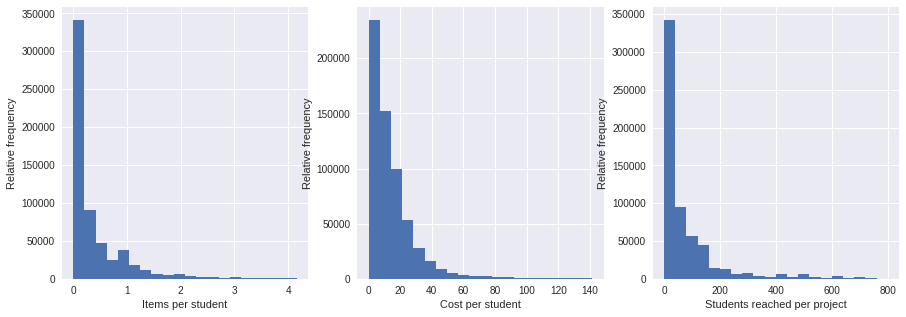

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(15, 5)

projects[projects['items_per_student'] < projects['items_per_student'].quantile(.99)]['items_per_student']\
    .hist(bins=20, ax=ax1)
ax1.set_xlabel('Items per student')
ax1.set_ylabel("Relative frequency")

projects[projects['cost_per_student'] < projects['cost_per_student'].quantile(.99)]['cost_per_student']\
    .hist(bins=20, ax=ax2)
ax2.set_xlabel('Cost per student')
ax2.set_ylabel("Relative frequency")

projects[projects['students_reached'] < projects['students_reached'].quantile(.99)]['students_reached']\
    .hist(bins=20, ax=ax3)
ax3.set_xlabel('Students reached per project')
ax3.set_ylabel("Relative frequency")

# 2: Case Study: Charter Schools and Poverty Levels

Charter schools serve very different functions based on student poverty levels. In wealthier areas, charter schools are often competitive schools of choice, whereas in poorer areas, charter schools are often schools that supplement systematic issues in surrounding public schools (example: accepting transfer students who were suspended from other public schools). 

Above, we see that teachers in wealthy charter schools tend to choose projects with the largest median cost per student, and that reach smaller sized classrooms, but still these projects get selected as "exciting" more often than any other charter school and poverty level combination.

There are some similarities between charter schools and non-charter schools across poverty levels. Charter schools tend to facilitate better parent-teacher relationships, which might explain why charter schools projects tend to have better project website engagemt (via "pct_great_chat")

In terms of project counts, we see that the majority of projects come from higher poverty schools, with more from non charter schools. However, in general we see that these schools are somewhat more likely to get their projects fully funded, requesting on average less per student. For schools that are systematically underfunded by local governments, there may be an incentive to apply for smaller amounts of money with a greater likelihood of receiving the funding. This also may disincentivize teachers from applying for novel projects, which may limit what is deemed "exciting" by DonorsChoose.org

In [24]:
projects.loc[:, 'school_charter_flag'] = np.where(projects['school_charter'] == 1, "Is charter", "Not charter")

In [25]:
charter_comp = projects.groupby(['school_charter_flag', 
                                 'poverty_level']).agg({'projectid': 'count', 
                                                        'fully_funded': np.mean, 
                                                        'great_chat': np.mean, 
                                                        'is_exciting': np.mean,
                                                        'cost_per_student': np.median, 
                                                        'students_reached': np.median})

In [26]:
charter_comp.rename(columns={'projectid': 'num_projects', 
                             'fully_funded': 'pct_fully_funded', 
                             'great_chat': 'pct_great_chat', 
                             'is_exciting': 'pct_is_exciting', 
                             'cost_per_student': 'median_cost_per_student', 
                             'students_reached': 'median_students_reached'}).round({
    'pct_fully_funded': 2, 
    'pct_great_chat': 2, 
    'pct_is_exciting': 2,
    'median_cost_per_student': 2,
    'median_students_reached': 0
})

num_projects  pct_fully_funded  \
school_charter_flag poverty_level                                      
Is charter          high poverty             13053              0.71   
                    highest poverty          33572              0.77   
                    low poverty               1862              0.68   
                    moderate poverty          4884              0.67   
Not charter         high poverty            148870              0.65   
                    highest poverty         324457              0.72   
                    low poverty              13399              0.67   
                    moderate poverty         78904              0.64   

                                      pct_great_chat  pct_is_exciting  \
school_charter_flag poverty_level                                       
Is charter          high poverty                0.34             0.08   
                    highest poverty             0.36             0.10   
                    low poverty                 0.35             0.12   
                    moderate poverty            0.32             0.09   
Not charter         high poverty                0.29             0.05   
                    highest poverty             0.30             0.06   
                    low poverty                 0.27             0.05   
                    moderate poverty            0.30             0.06   

                                      median_cost_per_student  \
school_charter_flag poverty_level                               
Is charter          high poverty                         8.38   
                    highest poverty                      8.06   
                    low poverty                         11.45   
                    moderate poverty                     9.75   
Not charter         high poverty                         9.64   
                    highest poverty                     10.46   
                    low poverty                         11.28   
                    moderate poverty                    10.30   

                                      median_students_reached  
school_charter_flag poverty_level                              
Is charter          high poverty                         49.0  
                    highest poverty                      50.0  
                    low poverty                          33.0  
                    moderate poverty                     37.0  
Not charter         high poverty                         31.0  
                    highest poverty                      30.0  
                    low poverty                          32.0  
                    moderate poverty                     30.0

# 3: Questions for the project partner

## Data questions

* It is unclear what makes up the total cost of a project. There are slight discrepancies between itemized costs in the resources data and the fulfillment labor and totals in the project data. This could be taxes, differences in estimated and actual total costs, fees charged by DonorsChoose.org, or something else.

* Many projects have extreme outlying qualities due to project proposal's self-reporting of data. For example, many projects claim to reach over thousands of students, or cost over hundreds of thousands of dollars. Since the overwhelming majority these proposals have modest budgets and target a single classroom, I would ask if DonorsChoose.org is interested in treating these extreme cases separately.

## Methodology questions

* How does DonorsChoose.org intend to use data from projects that are considered "exciting"? Since this term is a business construct, presumably there is a business goal in mind where "exciting" projects are more favorable for the organization and maybe for potential donors.

* Some of the criterion for "excitement" come from socioeconomically limiting factors, such as having a "green" donation (from credit card, check, or other trackable source of income), or having a non-referred donation over $100.00 in total. Depending on how excitement data is used, these biases could be reinforced by a model that simply reproduces these results. 

## Supplemental data questions

* I would be interested in supplemental data about the schools involved. Underfunded schools are likely to use DonorsChoose.org far differently than sufficiently funded schools, and information on how teachers close funding gaps using this platform would inform analysis of individual projects.

* Additionally, I would be interested in supplemental data about the teachers involved, including age and other standard self-reported demographic information that may already be available through DonorsChoose

# 4: Model Exploration

In this section, we will begin to develop a toy model for predicting "fully funded" projects. As a sanity check, we will investigate whether or not there are simple trends in the numerical predictors using a convential binomial GLM using the original data and log-transformed data (to attempt to tame the exponential decay). However, we find unsatisfactory fits compared to the true percentage of projects which get funded, 70%. 

In [27]:
cat_predictors = [
    'school_charter', 
    'school_magnet', 
    'school_year_round', 
    'school_nlns',
    'school_kipp',
    'school_charter_ready_promise',
    'teacher_prefix', 
    'teacher_teach_for_america',
    'teacher_ny_teaching_fellow',
    'poverty_level',
    'primary_focus_subject', 
    'primary_focus_area',
    'resource_type',
    'grade_level'
]
 
numeric_predictors = [
    'item_quantity',
    'items_per_student',
    'cost_per_student',
    'students_reached'
]

lognum_predictors = ['log_' + pred for pred in numeric_predictors]

target = ['fully_funded']

In [28]:
logreg = projects[numeric_predictors + target].replace([np.inf, -np.inf], np.nan).dropna()

logreg_filt = logreg[
    (logreg['item_quantity'] <= logreg['item_quantity'].quantile(.9999)) & 
    (logreg['items_per_student'] <= logreg['items_per_student'].quantile(.999))  & 
    (logreg['cost_per_student'] <= logreg['cost_per_student'].quantile(.999))  & 
    (logreg['students_reached'] <= logreg['students_reached'].quantile(.9999))
]

print("Dropped {} rows out of {}".format(len(projects) - len(logreg_filt), len(projects)))

Dropped 9980 rows out of 619001


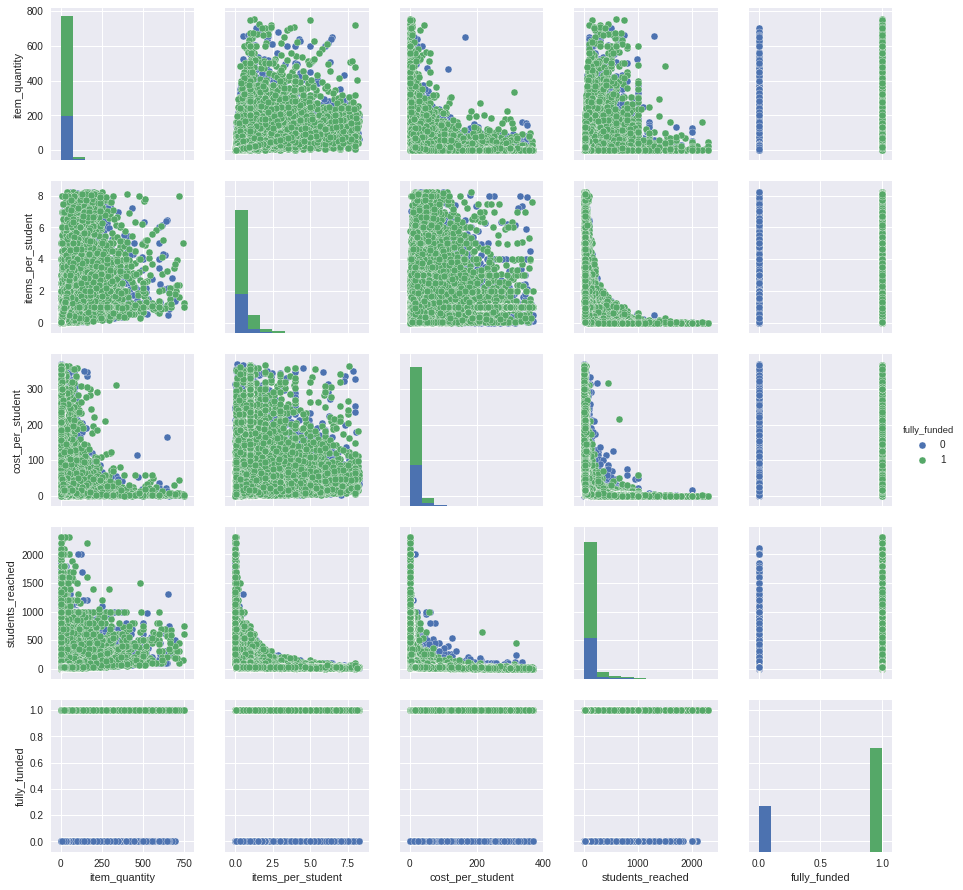

In [29]:
sns.pairplot(logreg_filt, hue='fully_funded')

In [31]:
for col in numeric_predictors: 
    logreg.loc[:, 'log_' + col] = np.log(logreg[col] + 1)

In [32]:
logreg_transform_filt = logreg[
    (logreg['log_item_quantity'] <= logreg['log_item_quantity'].quantile(.9999)) & 
    (logreg['log_items_per_student'] <= logreg['log_items_per_student'].quantile(.9999))  & 
    (logreg['log_cost_per_student'] <= logreg['log_cost_per_student'].quantile(.9999))  & 
    (logreg['log_students_reached'] <= logreg['log_students_reached'].quantile(.9999))
]

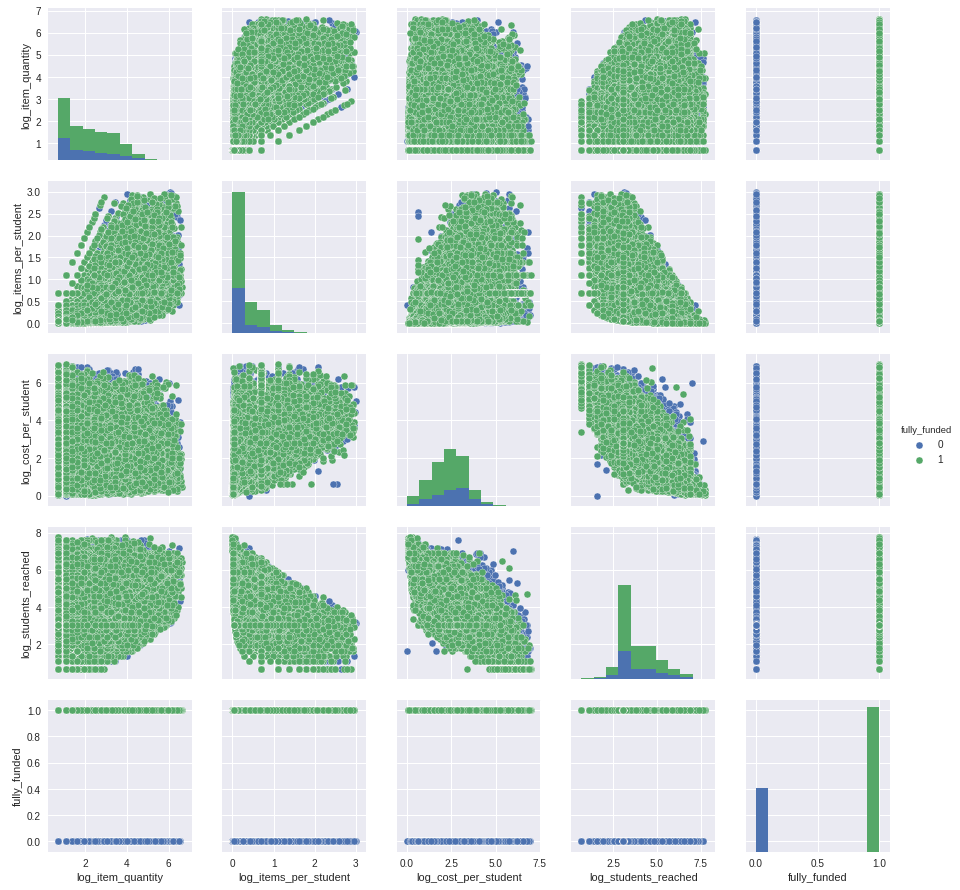

In [33]:
sns.pairplot(logreg_transform_filt[lognum_predictors + target], hue='fully_funded')

In [34]:
def train_test_logreg(df, preds):
    
    total_n = len(df)
    
    df.reset_index(inplace=True)
    df.drop('index', axis=1, inplace=True)
    
    train_ix = np.random.choice(range(total_n),
                                size=int(total_n * .9),
                                replace=False)
    
    test_ix = np.array(list(set(range(total_n)) - set(train_ix)))
    
    train_x = df.loc[train_ix, preds]
    test_x = df.loc[test_ix, preds]

    train_y = df.loc[train_ix, target]
    test_y = df.loc[test_ix, target]
    
    lmod = LogisticRegressionCV(fit_intercept=True, 
                                cv=10,
                                max_iter=200)
    
    fit_lmod = lmod.fit(train_x, train_y.values.ravel())
    print("Coefs: \n", preds, "\n", fit_lmod.coef_, "\n")
    
    return fit_lmod.score(test_x, test_y.values.ravel())
    

In [35]:
train_test_logreg(logreg_filt, numeric_predictors)

Coefs: 
 ['item_quantity', 'items_per_student', 'cost_per_student', 'students_reached'] 
 [[-0.00272421  0.26100131 -0.01567439 -0.00065092]] 



0.691952777367289

In [36]:
train_test_logreg(logreg_transform_filt, lognum_predictors)

Coefs: 
 ['log_item_quantity', 'log_items_per_student', 'log_cost_per_student', 'log_students_reached'] 
 [[ 0.09312017  0.11996545 -1.04236992 -0.8377657 ]] 



0.70003278151122772

As expected given the complexity of the project, these four cost-based predictors are not sufficient to determine what makes a project fully funded. 

In a separate analysis, we look at modeling different combinations of the categorical predictors defined above. Although we could start with a mixed effects model, given the number of parameters and complexity, we want to take a more adaptive approach. Instead, we will fit a random forest model to combine decision trees as a way of diagnosing different combinations of output in a more optimal manner. In addition to an improved model fit, we identified  categorical variables (resource_type, primary_focus_subject, poverty_level, grade_level) that have a stronger influence on fully funding than the other variables. This could be useful going forward in developing explicit models that depend on the covariance structure of these categorical variables. It could also inform model design, since this could indicate that, for example, projects of different resource type should be modeled separately.

In [37]:
h2o.init() 

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_151"; OpenJDK Runtime Environment (build 1.8.0_151-8u151-b12-0ubuntu0.16.04.2-b12); OpenJDK 64-Bit Server VM (build 25.151-b12, mixed mode)
  Starting server from /home/jeremy/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpeqq7s1fg
  JVM stdout: /tmp/tmpeqq7s1fg/h2o_jeremy_started_from_python.out
  JVM stderr: /tmp/tmpeqq7s1fg/h2o_jeremy_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster version:,3.16.0.4
H2O cluster version age:,"14 days, 14 hours and 23 minutes"
H2O cluster name:,H2O_from_python_jeremy_p3lnkz
H2O cluster total nodes:,1
H2O cluster free memory:,2.543 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


In [38]:
vs = projects[cat_predictors + target].values.tolist()

In [39]:
hf = H2OFrame(vs, column_names=cat_predictors + target)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [40]:
hf_x = hf.col_names[:-1] 
hf_y = hf.col_names[-1]
train, tune_params, test = hf.split_frame([.5, .25])

In [41]:
mod = H2ORandomForestEstimator(
    ntrees=200,
    score_each_iteration=True,
    seed=1234
)
mod.train(hf_x, hf_y, training_frame=train, validation_frame=tune_params)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [42]:
mod.score_history().tail(1)

,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
200,,2018-01-30 12:27:18,17 min 52.759 sec,200.0,0.455319,0.406113,0.207315,0.455821,0.406808,0.207772


In [43]:
mod._model_json['output']['variable_importances'].as_data_frame().round(2)

,variable,relative_importance,scaled_importance,percentage
0,resource_type,208783.47,1.00,0.25
1,primary_focus_subject,161680.53,0.77,0.19
2,grade_level,93752.62,0.45,0.11
3,poverty_level,90964.15,0.44,0.11
4,teacher_prefix,67521.53,0.32,0.08
5,primary_focus_area,51950.17,0.25,0.06
6,teacher_teach_for_america,38035.32,0.18,0.04
7,school_year_round,32104.61,0.15,0.04
8,school_magnet,32084.30,0.15,0.04
9,school_charter,26900.12,0.13,0.03


# 5: Plans for further modeling analysis

Given the time constraints of this evaluation project, there is no way to sufficiently understand and model this entire dataset in great detail. If we had more time, we would take a slower, more methodological approach to this analysis instead of quickly assembling a "first impression" from a couple hours of analysis, with the following goals:

* Improve data cleaning: under the time constraints, my data cleaning was done hastily to get a first impression of the data distribution. I would like to more closely analyze biases both in missing data and extreme numerical data, so that I can understand how best to interpolate this data instead of relying on inner joins, null value removal, and extreme value removal.

* Incorporate the categorical predictors and numerical predictors into a single model, then adding complexity: right now, I have split the two sets of predictors for simplicity's sake, but many models would be capable of combining the two from the start (example: mixed effect GLMs). It is true that random forests would be capable of parsing decision trees with both categorical and numerical values, however a concern with this approach is that numerical predictors, by having larger supports, have variance that can be more variably partitioned by a decision tree, causing these predictors to have excess relative importance in the final forest model compared to the categorical predictors. The impact of such an effect requires a better characterization of the data distribution.

* Look at other data sources: due to the time constriants (and my lack of NLP experience), data availability was a limiting factor in this analysis. In the numerical and categorical data I observed, there seemed to be a fair bit of homogeneity in project outcomes. Using text data from the essays and from the resource item names would allow for a much more detailed characterization of individual projects.